In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.applications import VGG16, VGG19, MobileNetV2
import matplotlib.pyplot as plt
import pathlib
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
import seaborn as sns

# Parameters
IMG_SIZE = 128
BATCH_SIZE = 16
CHANNEL = 3
EPOCHS = [20, 30, 40]
DATASET_PATH = pathlib.Path("/kaggle/input/plant-village/PlantVillage")

CLASS_NAMES = [
    "Tomato_Bacterial_spot", "Tomato_Early_blight", "Tomato_Late_blight",
    "Tomato_Leaf_Mold", "Tomato_Septoria_leaf_spot",
    "Tomato_Spider_mites_Two_spotted_spider_mite", "Tomato__Target_Spot",
    "Tomato__Tomato_YellowLeaf__Curl_Virus", "Tomato__Tomato_mosaic_virus",
    "Tomato_healthy"
]

# Load dataset
print("Loading dataset...")
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_PATH,
    labels="inferred",
    label_mode="int",
    shuffle=True,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_names=CLASS_NAMES
)

# Split dataset: 80% train, 10% val, 10% test
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + val_split + test_split) == 1
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size)
    
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

# Optimize datasets
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

print(f"Train batches: {len(train_ds)}, Val batches: {len(val_ds)}, Test batches: {len(test_ds)}")

# Data preprocessing and augmentation
rescaling_and_resizing = tf.keras.Sequential([
    layers.Resizing(IMG_SIZE, IMG_SIZE),
    layers.Rescaling(1.0/255)
])

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
])

2025-11-03 13:21:01.801525: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762176062.072595      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762176062.149078      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Loading dataset...
Found 16011 files belonging to 10 classes.


I0000 00:00:1762176100.669496      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Train batches: 800, Val batches: 100, Test batches: 101


In [2]:
# Model creation functions
def create_vgg16_transfer(input_shape=(IMG_SIZE, IMG_SIZE, CHANNEL), num_classes=10):
    """VGG16 with transfer learning from ImageNet"""
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False
    
    model = models.Sequential([
        rescaling_and_resizing,
        data_augmentation,
        base_model,
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

def create_vgg19_transfer(input_shape=(IMG_SIZE, IMG_SIZE, CHANNEL), num_classes=10):
    """VGG19 with transfer learning from ImageNet"""
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False
    
    model = models.Sequential([
        rescaling_and_resizing,
        data_augmentation,
        base_model,
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

def create_custom_model():
    """Custom CNN model"""
    model = models.Sequential([
        rescaling_and_resizing,
        data_augmentation,
        
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(256, (3, 3), padding='same'),
        layers.LeakyReLU(alpha=0.1),
        layers.Conv2D(256, (3, 3), padding='same'),
        layers.LeakyReLU(alpha=0.1),
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    return model
    
def create_mobilenetv2_transfer(input_shape=(IMG_SIZE, IMG_SIZE, CHANNEL), num_classes=10):
    """MobileNetV2 with transfer learning from ImageNet"""
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # freeze pretrained layers

    model = models.Sequential([
        rescaling_and_resizing,
        data_augmentation,
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model
# Compile and train function
def train_model(model, model_name, epochs):
    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )
    
    print(f"\nTraining {model_name} for {epochs} epochs...")
    history = model.fit(
        train_ds,
        batch_size=BATCH_SIZE,
        validation_data=val_ds,
        epochs=epochs,
        verbose=1
    )
    return model, history

In [3]:
# Training with incremental epochs and checkpoint saving
print("\n" + "="*60)
print("CREATING AND TRAINING MODELS")
print("="*60)

trained_models = {}
all_histories = {}
model_architectures = {
    'Custom_CNN': create_custom_model,
    'VGG16': create_vgg16_transfer,
    'VGG19': create_vgg19_transfer,
    'MobileNetV2': create_mobilenetv2_transfer
}

EPOCHS_LIST = [20, 30, 40, 50]

# Train models at different epochs
for model_name, model_func in model_architectures.items():
    print(f"\n{model_name}:")
    
    # CREATE ONE MODEL INSTANCE PER ARCHITECTURE
    model = model_func()
    
    # Compile once
    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )
    
    # Build model by running on one batch
    for sample_images, sample_labels in train_ds.take(1):
        _ = model.predict(sample_images, verbose=0)
    
    print(f"  Model Parameters: {model.count_params():,}")
    
    # Track cumulative epochs
    trained_so_far = 0
    all_histories_combined = {
        'accuracy': [],
        'val_accuracy': [],
        'loss': [],
        'val_loss': []
    }
    
    for epoch_count in EPOCHS_LIST:
        # Calculate how many epochs to train in this iteration
        epochs_to_train = epoch_count - trained_so_far
        
        key = f"{model_name}_ep{epoch_count}"
        
        # Train incrementally
        print(f"\n  Training {model_name} for {epochs_to_train} more epochs (total: {epoch_count})...")
        history = model.fit(
            train_ds,
            batch_size=BATCH_SIZE,
            validation_data=val_ds,
            epochs=epochs_to_train,
            verbose=1
        )
        
        # Accumulate history
        all_histories_combined['accuracy'].extend(history.history['accuracy'])
        all_histories_combined['val_accuracy'].extend(history.history['val_accuracy'])
        all_histories_combined['loss'].extend(history.history['loss'])
        all_histories_combined['val_loss'].extend(history.history['val_loss'])
        
        # Evaluate on test set
        test_loss, test_acc = model.evaluate(test_ds, verbose=0)
        print(f"  ✓ Test Accuracy at {epoch_count} epochs: {test_acc:.4f}")
        
        # SAVE model checkpoint to disk
        checkpoint_path = f'/kaggle/working/{key}_model.h5'
        model.save(checkpoint_path)
        print(f"  ✓ Saved checkpoint: {checkpoint_path}")
        
        # Store model and history in memory
        trained_models[key] = model
        
        # Create history object with accumulated history
        all_histories[key] = type('History', (), {'history': all_histories_combined.copy()})()
        
        # Update trained epochs count
        trained_so_far = epoch_count

print("\n" + "="*60)
print("All models trained and checkpoints saved!")
print("="*60)
print("\nSaved Checkpoints:")
for key in trained_models.keys():
    print(f"  - {key}_model.h5")


CREATING AND TRAINING MODELS

Custom_CNN:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
I0000 00:00:1762176138.297268      66 cuda_dnn.cc:529] Loaded cuDNN version 90300


  Model Parameters: 1,240,618

  Training Custom_CNN for 20 more epochs (total: 20)...
Epoch 1/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 32s 31ms/step - accuracy: 0.2585 - loss: 2.0108 - val_accuracy: 0.3762 - val_loss: 1.7040
Epoch 2/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.4160 - loss: 1.6385 - val_accuracy: 0.4663 - val_loss: 1.4927
Epoch 3/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.5063 - loss: 1.3901 - val_accuracy: 0.5063 - val_loss: 1.4437
Epoch 4/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.5974 - loss: 1.1069 - val_accuracy: 0.6806 - val_loss: 0.9311
Epoch 5/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.7066 - loss: 0.8220 - val_accuracy: 0.6463 - val_loss: 1.1910
Epoch 6/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.7535 - loss: 0.7100 - val_accuracy: 0.7638 - val_loss: 0.6922
Epoch 7/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.7874 - loss: 0.6028 - val_accuracy: 0.8269 - val_loss: 0.5015
Epo


MODEL EVALUATION AND COMPARISON
VGG16_ep20: 0.6423
VGG16_ep30: 0.7141
VGG16_ep40: 0.6894
VGG16_ep50: 0.6176
VGG19_ep20: 0.6170
VGG19_ep30: 0.5557
VGG19_ep40: 0.4895
VGG19_ep50: 0.4839
Custom_CNN_ep20: 0.9338
Custom_CNN_ep30: 0.9610
Custom_CNN_ep40: 0.9196
Custom_CNN_ep50: 0.9728
MobileNetV2_ep20: 0.8150
MobileNetV2_ep30: 0.8422
MobileNetV2_ep40: 0.8416
MobileNetV2_ep50: 0.8311

✓ Best Model: Custom_CNN_ep50 with accuracy 0.9728
✓ Saved: 01_model_comparison_accuracy.pdf
✓ Saved: 01_model_comparison_accuracy.svg


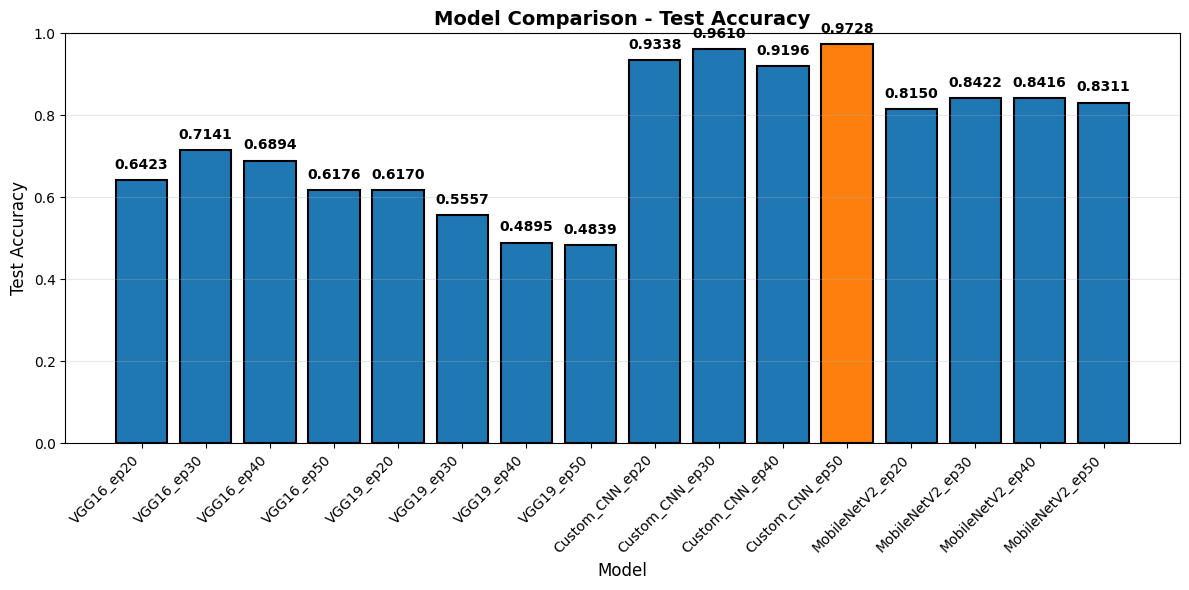


DETAILED ANALYSIS OF BEST MODEL: Custom_CNN_ep50

Classification Report:
                                             precision    recall  f1-score   support

                      Tomato_Bacterial_spot     0.9764    0.9904    0.9834       209
                        Tomato_Early_blight     0.9300    0.9789    0.9538        95
                         Tomato_Late_blight     0.9892    0.9534    0.9710       193
                           Tomato_Leaf_Mold     0.8598    1.0000    0.9246        92
                  Tomato_Septoria_leaf_spot     0.9563    0.9459    0.9511       185
Tomato_Spider_mites_Two_spotted_spider_mite     0.9881    0.9651    0.9765       172
                        Tomato__Target_Spot     1.0000    0.9328    0.9653       134
      Tomato__Tomato_YellowLeaf__Curl_Virus     0.9940    0.9881    0.9911       337
                Tomato__Tomato_mosaic_virus     0.9394    0.9394    0.9394        33
                             Tomato_healthy     0.9940    1.0000    0.9970 

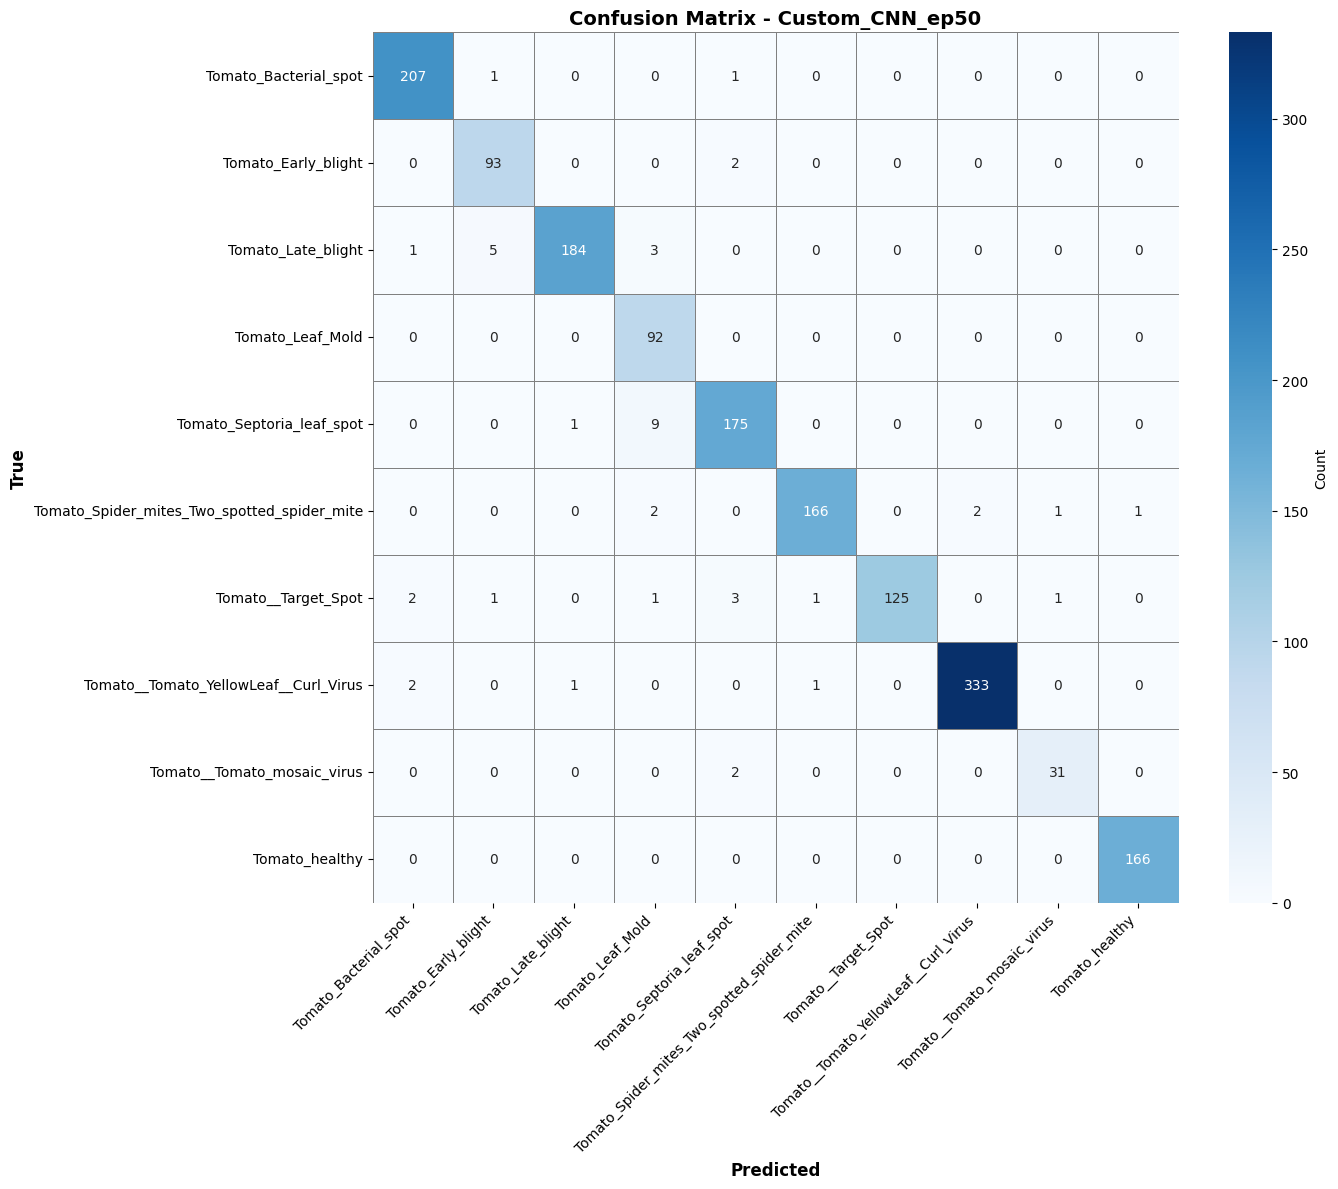


Note: Training history plots require history to be saved during training.
If you have saved all_histories, you can use that for training curves.

Evaluation complete!


In [4]:
# Evaluate models from saved checkpoints
print("\n" + "="*60)
print("MODEL EVALUATION AND COMPARISON")
print("="*60)

# Define checkpoint paths
checkpoint_dir = '/kaggle/working'
CHECKPOINTS = {
    'VGG16_ep20': f'{checkpoint_dir}/VGG16_ep20_model.h5',
    'VGG16_ep30': f'{checkpoint_dir}/VGG16_ep30_model.h5',
    'VGG16_ep40': f'{checkpoint_dir}/VGG16_ep40_model.h5',
    'VGG16_ep50': f'{checkpoint_dir}/VGG16_ep50_model.h5',
    'VGG19_ep20': f'{checkpoint_dir}/VGG19_ep20_model.h5',
    'VGG19_ep30': f'{checkpoint_dir}/VGG19_ep30_model.h5',
    'VGG19_ep40': f'{checkpoint_dir}/VGG19_ep40_model.h5',
    'VGG19_ep50': f'{checkpoint_dir}/VGG19_ep50_model.h5',
    'Custom_CNN_ep20': f'{checkpoint_dir}/Custom_CNN_ep20_model.h5',
    'Custom_CNN_ep30': f'{checkpoint_dir}/Custom_CNN_ep30_model.h5',
    'Custom_CNN_ep40': f'{checkpoint_dir}/Custom_CNN_ep40_model.h5',
    'Custom_CNN_ep50': f'{checkpoint_dir}/Custom_CNN_ep50_model.h5',
    'MobileNetV2_ep20': f'{checkpoint_dir}/MobileNetV2_ep20_model.h5',
    'MobileNetV2_ep30': f'{checkpoint_dir}/MobileNetV2_ep30_model.h5',
    'MobileNetV2_ep40': f'{checkpoint_dir}/MobileNetV2_ep40_model.h5',
    'MobileNetV2_ep50': f'{checkpoint_dir}/MobileNetV2_ep50_model.h5',
}

best_model_name = None
best_accuracy = 0
best_model = None
results = {}
loaded_models = {}

# Load and evaluate all checkpoints
for model_key, checkpoint_path in CHECKPOINTS.items():
    try:
        model = tf.keras.models.load_model(checkpoint_path)
        loaded_models[model_key] = model
        test_loss, test_acc = model.evaluate(test_ds, verbose=0)
        results[model_key] = test_acc
        print(f"{model_key}: {test_acc:.4f}")
        
        if test_acc > best_accuracy:
            best_accuracy = test_acc
            best_model_name = model_key
            best_model = model
    except Exception as e:
        print(f"{model_key}: Error loading - {str(e)}")

print(f"\n✓ Best Model: {best_model_name} with accuracy {best_accuracy:.4f}")

# Plot accuracy comparison
plt.figure(figsize=(12, 6))
model_names = list(results.keys())
accuracies = list(results.values())
colors = ['#ff7f0e' if acc == best_accuracy else '#1f77b4' for acc in accuracies]
plt.bar(model_names, accuracies, color=colors, edgecolor='black', linewidth=1.5)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Test Accuracy', fontsize=12)
plt.title('Model Comparison - Test Accuracy', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.ylim([0, 1])
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.02, f'{v:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(f'/kaggle/working/01_model_comparison_accuracy.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.savefig(f'/kaggle/working/01_model_comparison_accuracy.svg', format='svg', bbox_inches='tight')
print(f"✓ Saved: 01_model_comparison_accuracy.pdf")
print(f"✓ Saved: 01_model_comparison_accuracy.svg")
plt.show()

# Detailed analysis of best model
print("\n" + "="*60)
print(f"DETAILED ANALYSIS OF BEST MODEL: {best_model_name}")
print("="*60)

# Collect predictions and true labels
y_true = []
y_pred = []
for images, labels in test_ds:
    y_true.extend(labels.numpy())
    preds = best_model.predict(images, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Classification metrics
print("\nClassification Report:")
class_report = classification_report(y_true, y_pred, target_names=CLASS_NAMES, digits=4)
print(class_report)

# Save classification report to file
with open(f'/kaggle/working/02_classification_report.txt', 'w') as f:
    f.write(f"CLASSIFICATION REPORT - {best_model_name}\n")
    f.write("="*80 + "\n\n")
    f.write(class_report)
    f.write("\n\n" + "="*80 + "\n")
print(f"✓ Saved: 02_classification_report.txt")

# Calculate macro and weighted metrics
f1_macro = f1_score(y_true, y_pred, average='macro')
f1_weighted = f1_score(y_true, y_pred, average='weighted')
precision_macro = precision_score(y_true, y_pred, average='macro')
precision_weighted = precision_score(y_true, y_pred, average='weighted')
recall_macro = recall_score(y_true, y_pred, average='macro')
recall_weighted = recall_score(y_true, y_pred, average='weighted')

print(f"\nMacro Metrics:")
print(f"  F1 Score: {f1_macro:.4f}")
print(f"  Precision: {precision_macro:.4f}")
print(f"  Recall: {recall_macro:.4f}")

print(f"\nWeighted Metrics:")
print(f"  F1 Score: {f1_weighted:.4f}")
print(f"  Precision: {precision_weighted:.4f}")
print(f"  Recall: {recall_weighted:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, 
            cmap='Blues', cbar_kws={'label': 'Count'}, linewidths=0.5, linecolor='gray')
plt.xlabel('Predicted', fontsize=12, fontweight='bold')
plt.ylabel('True', fontsize=12, fontweight='bold')
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(f'/kaggle/working/03_confusion_matrix.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.savefig(f'/kaggle/working/03_confusion_matrix.svg', format='svg', bbox_inches='tight')
print(f"✓ Saved: 03_confusion_matrix.pdf")
print(f"✓ Saved: 03_confusion_matrix.svg")
plt.show()

# Note: Training history not available when loading from checkpoints
# If you need training history, it must be saved separately during training
print("\nNote: Training history plots require history to be saved during training.")
print("If you have saved all_histories, you can use that for training curves.")

print("\n" + "="*60)
print("Evaluation complete!")
print("="*60)


COMBINED TRAINING CURVES FOR ALL MODELS


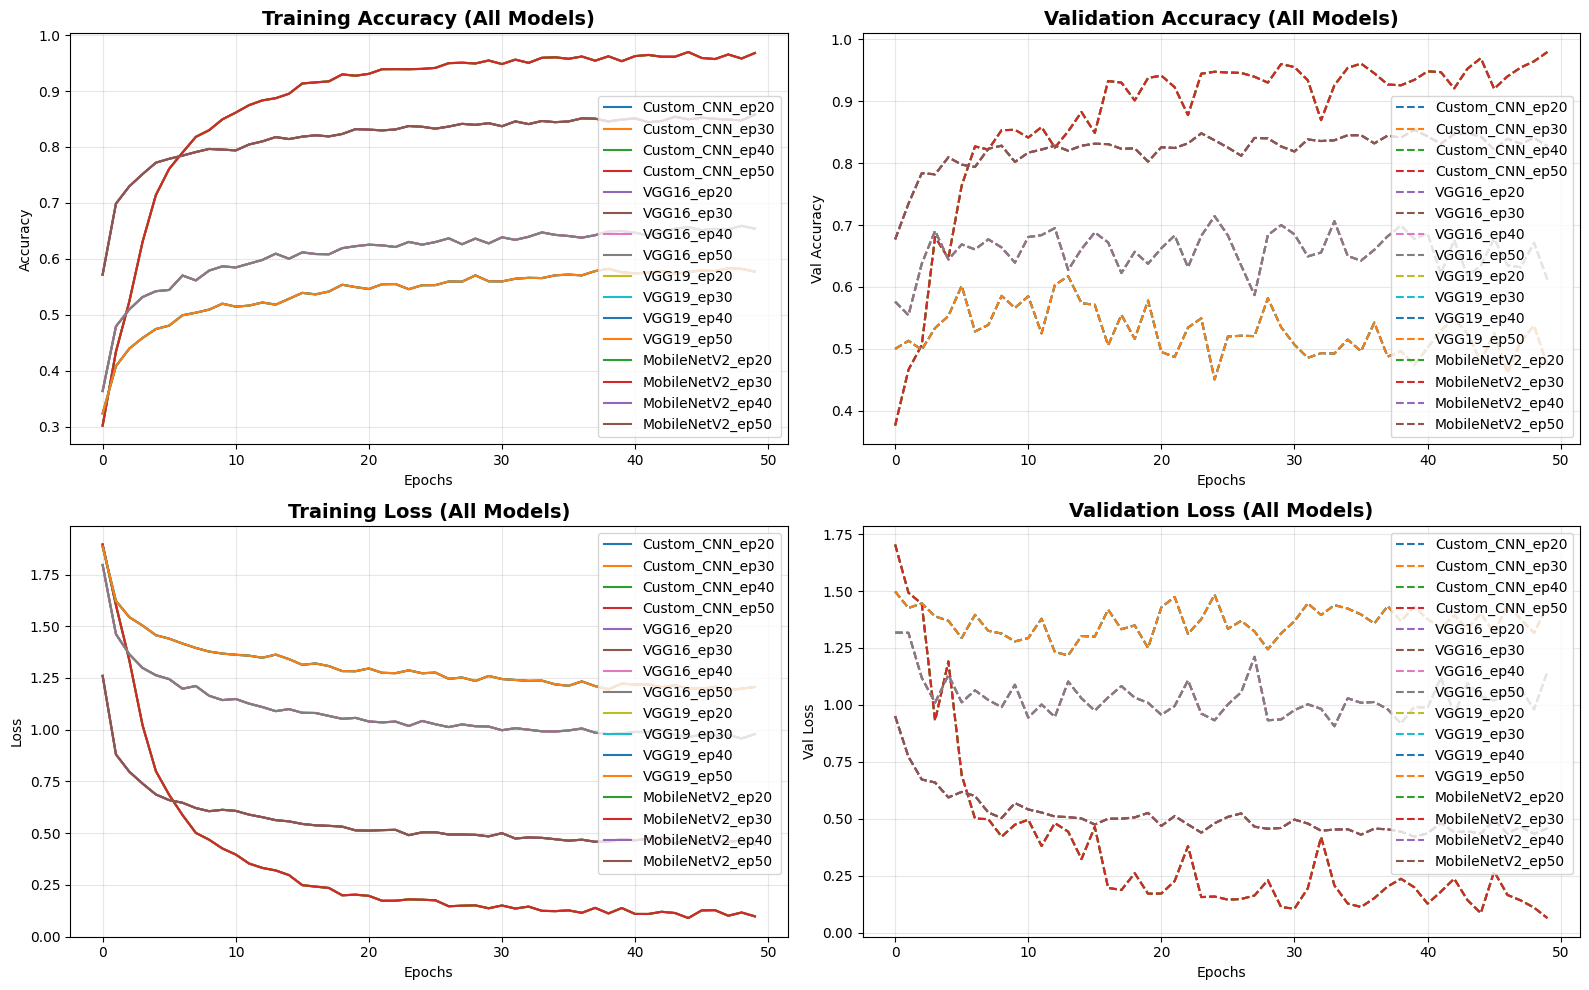

✓ Saved: /kaggle/working/all_models_combined_curves.pdf
✓ Saved: /kaggle/working/all_models_combined_curves.svg


In [5]:
import matplotlib.pyplot as plt

# ==========================================
# COMBINED CURVES FOR ALL MODELS
# ==========================================
print("\n" + "="*60)
print("COMBINED TRAINING CURVES FOR ALL MODELS")
print("="*60)

plt.figure(figsize=(16, 10))

# Define 4 subplots: Train Acc, Val Acc, Train Loss, Val Loss
plt.subplot(2, 2, 1)
for model_name, hist_obj in all_histories.items():
    plt.plot(hist_obj.history['accuracy'], label=f'{model_name}')
plt.title('Training Accuracy (All Models)', fontsize=14, fontweight='bold')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(2, 2, 2)
for model_name, hist_obj in all_histories.items():
    plt.plot(hist_obj.history['val_accuracy'], linestyle='--', label=f'{model_name}')
plt.title('Validation Accuracy (All Models)', fontsize=14, fontweight='bold')
plt.xlabel('Epochs')
plt.ylabel('Val Accuracy')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(2, 2, 3)
for model_name, hist_obj in all_histories.items():
    plt.plot(hist_obj.history['loss'], label=f'{model_name}')
plt.title('Training Loss (All Models)', fontsize=14, fontweight='bold')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(2, 2, 4)
for model_name, hist_obj in all_histories.items():
    plt.plot(hist_obj.history['val_loss'], linestyle='--', label=f'{model_name}')
plt.title('Validation Loss (All Models)', fontsize=14, fontweight='bold')
plt.xlabel('Epochs')
plt.ylabel('Val Loss')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
pdf_path = '/kaggle/working/all_models_combined_curves.pdf'
svg_path = '/kaggle/working/all_models_combined_curves.svg'
plt.savefig(pdf_path, format='pdf', bbox_inches='tight', dpi=300)
plt.savefig(svg_path, format='svg', bbox_inches='tight')
plt.show()

print(f"✓ Saved: {pdf_path}")
print(f"✓ Saved: {svg_path}")



SAMPLE PREDICTIONS
✓ Saved: 05_sample_predictions.pdf
✓ Saved: 05_sample_predictions.svg


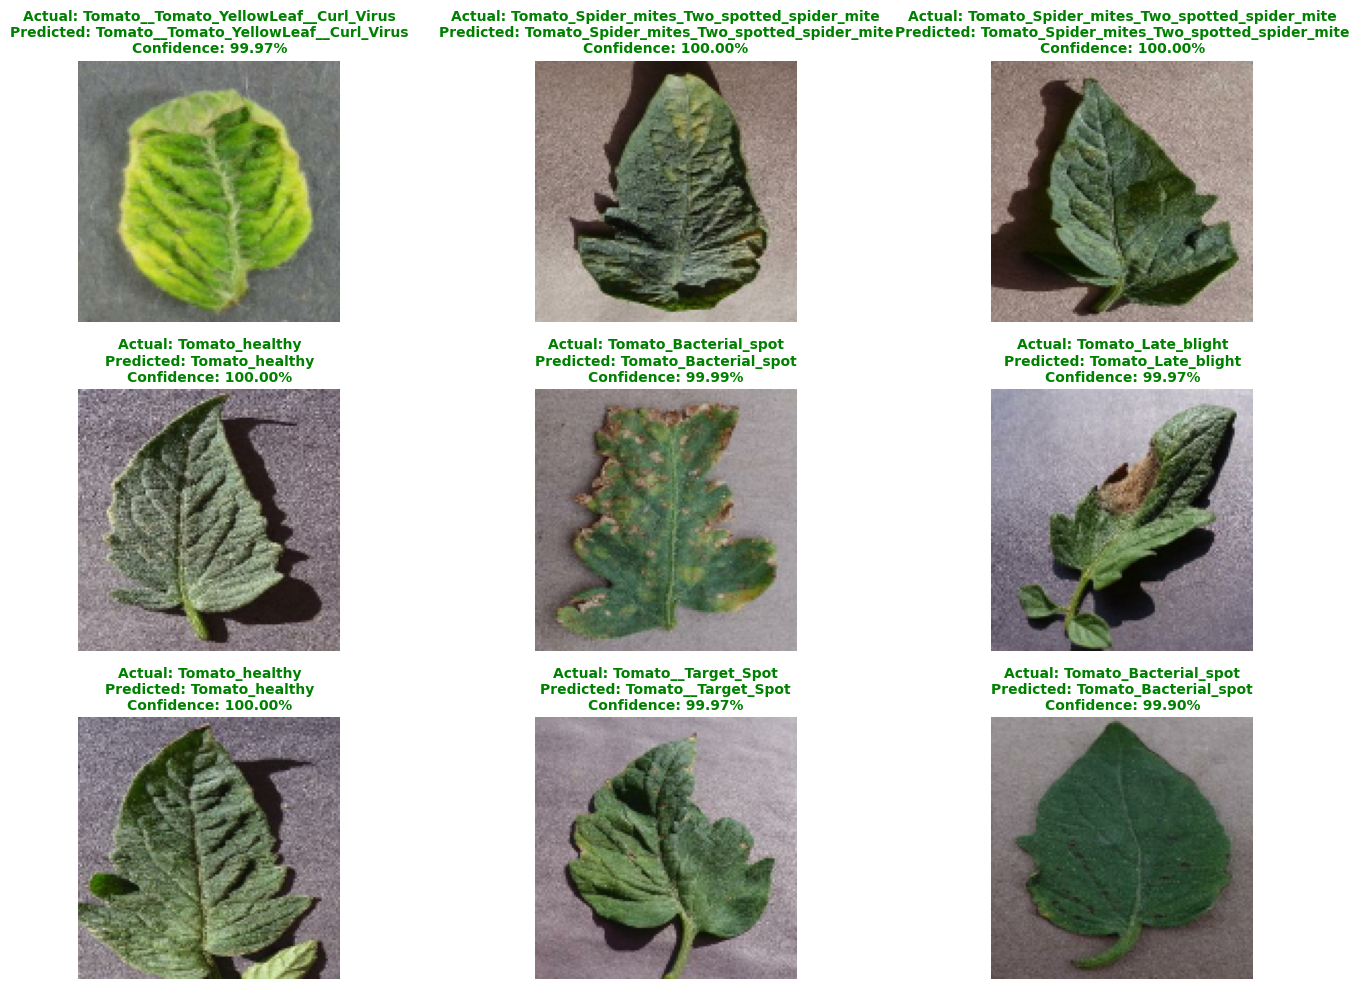

✓ Saved: 05_sample_predictions.csv
✓ Saved: 05_sample_predictions_table.txt
✓ Saved: 05_sample_predictions.json


In [6]:
import pandas as pd
import json
# Sample predictions
print("\n" + "="*60)
print("SAMPLE PREDICTIONS")
print("="*60)

plt.figure(figsize=(15, 10))
sample_predictions = []

for images, labels in test_ds.take(1):
    for i in range(min(9, len(images))):
        img = images[i].numpy().astype('uint8')
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        
        img_input = tf.expand_dims(images[i], 0)
        preds = best_model.predict(img_input, verbose=0)
        pred_idx = np.argmax(preds[0])
        confidence = preds[0][pred_idx]
        
        actual_class = CLASS_NAMES[labels[i].numpy()]
        predicted_class = CLASS_NAMES[pred_idx]
        is_correct = actual_class == predicted_class
        
        sample_predictions.append({
            'Sample': i + 1,
            'Actual Class': actual_class,
            'Predicted Class': predicted_class,
            'Confidence (%)': round(float(confidence) * 100, 2),
            'Correct': 'Yes' if is_correct else 'No'
        })
        
        color = 'green' if is_correct else 'red'
        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence:.2%}", 
                  color=color, fontsize=10, fontweight='bold')
        plt.axis('off')

plt.tight_layout()
plt.savefig(f'/kaggle/working/05_sample_predictions.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.savefig(f'/kaggle/working/05_sample_predictions.svg', format='svg', bbox_inches='tight')
print(f"✓ Saved: 05_sample_predictions.pdf")
print(f"✓ Saved: 05_sample_predictions.svg")
plt.show()

# Save sample predictions as CSV (easy to use in paper)
df_predictions = pd.DataFrame(sample_predictions)
df_predictions.to_csv(f'/kaggle/working/05_sample_predictions.csv', index=False)
print(f"✓ Saved: 05_sample_predictions.csv")

# Save as formatted text table
with open(f'/kaggle/working/05_sample_predictions_table.txt', 'w') as f:
    f.write("SAMPLE PREDICTIONS TABLE\n")
    f.write("="*100 + "\n\n")
    f.write(df_predictions.to_string(index=False))
    f.write("\n\n" + "="*100 + "\n")
    correct_count = (df_predictions['Correct'] == 'Yes').sum()
    total_count = len(df_predictions)
    accuracy = (correct_count / total_count * 100)
    f.write(f"Accuracy: {correct_count}/{total_count} = {accuracy:.2f}%\n")
print(f"✓ Saved: 05_sample_predictions_table.txt")

# Save sample predictions to JSON
with open(f'/kaggle/working/05_sample_predictions.json', 'w') as f:
    json.dump(sample_predictions, f, indent=4)
print(f"✓ Saved: 05_sample_predictions.json")

In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import json
from datetime import datetime

print("\n" + "="*60)
print("SALIENCY MAP ANALYSIS")
print("="*60)

def compute_saliency_map(model, img_array, class_index=None):
    """
    Computes saliency map indicating which pixels most influenced prediction.
    """
    img_array = tf.cast(img_array, tf.float32)
    img_array = tf.Variable(img_array)

    with tf.GradientTape() as tape:
        tape.watch(img_array)
        predictions = model(img_array)
        if class_index is None:
            class_index = tf.argmax(predictions[0])
        score = predictions[:, class_index]

    grads = tape.gradient(score, img_array)
    saliency = tf.reduce_max(tf.abs(grads), axis=-1)[0]
    saliency /= (tf.reduce_max(saliency) + 1e-10)
    return saliency.numpy(), int(class_index)

def show_saliency_on_image(saliency, image, predicted_class, true_class, confidence, sample_num, alpha=0.6):
    """
    Overlays saliency map on the original image and saves the visualization.
    """
    if image.max() <= 1.0:
        display_img = (image * 255).astype(np.uint8)
    elif image.min() < 0:
        display_img = ((image + 1) * 127.5).astype(np.uint8)
    else:
        display_img = image.astype(np.uint8)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(display_img)
    axes[0].set_title("Original Image")
    axes[0].axis("off")
    
    im = axes[1].imshow(saliency, cmap='hot')
    plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04, label='Importance')
    axes[1].set_title("Saliency Map\n(Red = Important regions)")
    axes[1].axis("off")
    
    axes[2].imshow(display_img)
    axes[2].imshow(saliency, cmap='hot', alpha=alpha)
    axes[2].set_title(f"Overlay\nTrue: {true_class}\nPred: {predicted_class} ({confidence:.2%})")
    axes[2].axis("off")

    plt.tight_layout()
    plt.savefig(f'/kaggle/working/06_saliency_map_sample{sample_num}.pdf', format='pdf', bbox_inches='tight')
    plt.savefig(f'/kaggle/working/06_saliency_map_sample{sample_num}.svg', format='svg', bbox_inches='tight')
    plt.close(fig)

# Generate saliency maps
print("Generating saliency maps for test samples...\n")
sample_num = 0
for images, labels in test_ds.take(2):
    for i in range(min(3, len(images))):
        img_array = images[i].numpy()
        img_input = tf.expand_dims(images[i], 0)
        
        true_label_idx = labels[i].numpy()
        true_class = CLASS_NAMES[true_label_idx]
        
        preds = best_model.predict(img_input, verbose=0)
        pred_idx = np.argmax(preds[0])
        pred_class = CLASS_NAMES[pred_idx]
        confidence = preds[0][pred_idx]
        
        saliency, _ = compute_saliency_map(best_model, img_input, class_index=pred_idx)
        
        sample_num += 1
        print(f"Sample {sample_num}: True={true_class}, Predicted={pred_class}, Confidence={confidence:.2%}")
        show_saliency_on_image(saliency, img_array, pred_class, true_class, confidence, sample_num)
        print(f"✓ Saved saliency maps for Sample {sample_num}")

# Save comprehensive results summary
current_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
results_summary = {
    'timestamp': current_time,
    'best_model': best_model_name,
    'best_accuracy': float(best_accuracy),
    'all_model_results': {k: float(v) for k, v in results.items()},
    'metrics': {
        'f1_macro': float(f1_macro),
        'f1_weighted': float(f1_weighted),
        'precision_macro': float(precision_macro),
        'recall_macro': float(recall_macro)
    },
    'dataset_split': {
        'train_batches': len(train_ds),
        'val_batches': len(val_ds),
        'test_batches': len(test_ds)
    },
    'hyperparameters': {
        'image_size': IMG_SIZE,
        'batch_size': BATCH_SIZE,
        'epochs_tested': EPOCHS
    }
}

with open('/kaggle/working/07_results_summary.json', 'w') as f:
    json.dump(results_summary, f, indent=4)
print("✓ Saved: 07_results_summary.json")

print("\n" + "="*60)
print("ALL RESULTS SAVED TO: /kaggle/working/")
print("="*60)
print("\n📊 VECTOR GRAPHICS:")
print("  ✓ 06_saliency_map_sample*.pdf/.svg")
print("\n📄 DATA FILES:")
print("  ✓ 07_results_summary.json")



SALIENCY MAP ANALYSIS
Generating saliency maps for test samples...



I0000 00:00:1762179281.182392      19 cuda_solvers.cc:178] Creating GpuSolver handles for stream 0x40c872a0


Sample 1: True=Tomato__Tomato_YellowLeaf__Curl_Virus, Predicted=Tomato__Tomato_YellowLeaf__Curl_Virus, Confidence=99.97%
✓ Saved saliency maps for Sample 1
Sample 2: True=Tomato_Spider_mites_Two_spotted_spider_mite, Predicted=Tomato_Spider_mites_Two_spotted_spider_mite, Confidence=100.00%
✓ Saved saliency maps for Sample 2
Sample 3: True=Tomato_Spider_mites_Two_spotted_spider_mite, Predicted=Tomato_Spider_mites_Two_spotted_spider_mite, Confidence=100.00%
✓ Saved saliency maps for Sample 3
Sample 4: True=Tomato_healthy, Predicted=Tomato_healthy, Confidence=99.93%
✓ Saved saliency maps for Sample 4
Sample 5: True=Tomato__Tomato_YellowLeaf__Curl_Virus, Predicted=Tomato__Tomato_YellowLeaf__Curl_Virus, Confidence=100.00%
✓ Saved saliency maps for Sample 5
Sample 6: True=Tomato_Septoria_leaf_spot, Predicted=Tomato_Leaf_Mold, Confidence=57.28%
✓ Saved saliency maps for Sample 6
✓ Saved: 07_results_summary.json

ALL RESULTS SAVED TO: /kaggle/working/

📊 VECTOR GRAPHICS:
  ✓ 06_saliency_map_sam